In [ ]:
#DEFINE THIS FUNCTION

def overlay_cross(img,cross_pos,cross_colour=[255,0,0],cross_size=11):
    
    if not cross_size%2: #if even make it odd!
        cross_size+=1
    
    mid=int(cross_size/2)
    
    nx,ny,nz=img.shape
    out=img.astype(int)
    (x,y)=cross_pos
    x=int(x)
    y=int(y)
    
    for i in range(cross_size):
        idx_x=x-mid+i
        idx_y=y-mid+i
        
        if idx_y<0:
            idx_y=0
        elif idx_y>=ny:
            idx_y=ny
            
        if idx_x<0:
            idx_x=0
        elif idx_x>=nx:
            idx_x=nx
        
        out[idx_x][y][0]=cross_colour[0]
        out[idx_x][y][1]=cross_colour[1]
        out[idx_x][y][2]=cross_colour[2]
        
        out[x][idx_y][0]=cross_colour[0]
        out[x][idx_y][1]=cross_colour[1]
        out[x][idx_y][2]=cross_colour[2]
        
    return out

In [75]:
import IP.basic_ip as IP
import IP.morphological_edge_detection as IP_med
import numpy as np
from skimage.color import rgb2gray
import skimage.filters as flt
from scipy import ndimage

#init variables:
edges=[]
labels=[]
objects=[]
nb_objects=np.array([0,0,0])
tot_black_px=np.array([0,0,0])
tot_blue_px=np.array([0,0,0])
min_size=np.array([-1,-1,-1])
detected_objects_img=[]

#contour extraction params:
channel=1 #Green
nb_img=images.shape[0]

G_t1=0.09
G_t2=1
thresholding=False
smoothin_sigma=1

#extract objects params:
contour_label=0.0 #if this label: is is contour

#classify params
#note that blue has greater intensity in B channel and black/white is kinda homogeneous
eps_black=20 #if channel values are in relative range: is black
background_limit=5000 #if greater than this limit: is background
form_limit=100 #if smaller than this limit: is noise

print_full_analysis=False

#img analysis algorithm:
for i in range(nb_img):
    #contour extraction:
    img=images[i]
    img=IP.minmax(img[:,:,channel],255) #normalize image minmax to [0,255]
    (temp,_,_,_,_)=IP_med.skeletonize_based_sobel(img,smoothin_sigma,0,0,G_t1,G_t2,thresholding)
    edges.append(temp)
    
    #labelize:
    edgeMap=edges[i]
    edgeMap = -np.array(edgeMap).astype(int) #convert edges to negative values
    temp = labelizePixels(edgeMap)
    labels.append(temp)

    unique_labels=np.unique(labels[i])
    
    #normalize img minmax:
    img=images[i]
    img=np.dstack((IP.minmax(img[:,:,0],255),IP.minmax(img[:,:,1],255),IP.minmax(img[:,:,2],255)))
    
    #object extraction:
    #prepare image for overlaying cross at object position
    img_cross_overlay=img.copy()
    
    #get for each label its object data
    #count features
    nb_blue=0
    nb_black=0
    noise=0
    background=0
        
    print("Image %d:" %(i+1))
    
    #numeration logic of stored objects
    if i==0:
        idx_shift=0
    else:
        idx_shift+=nb_objects[i-1]
    
    for j,label in enumerate(unique_labels):
        #pixels of object
        label_idx=labels[i]==label
        
        (x,y)=ndimage.measurements.center_of_mass(label_idx.astype(int))
        COM=(int(x),int(y))
        
        extracted_form=img[label_idx,:]
        shape_size=extracted_form.shape[0]
        average_color=np.sum(extracted_form,0)/nb_px
        
        nb_objects[i]=j+1
        
               
        #classify based on color thresholding:
        if shape_size>background_limit:
            is_object=False
            objects.append((is_object,average_color.astype(int),shape_size,COM,label,"background"))
            background+=1
        elif shape_size<form_limit:
            is_object=False
            objects.append((is_object,average_color.astype(int),shape_size,COM,label,"noise"))
            noise+=1
        elif label==contour_label:
            is_object=False
            objects.append((is_object,average_color.astype(int),shape_size,COM,label,"contour"))
        elif average_color[0]-eps_black<average_color[1]<average_color[0]+eps_black and average_color[0]-eps_black<average_color[2]<average_color[0]+eps_black:
            is_object=True
            objects.append((is_object,average_color.astype(int),shape_size,COM,label,"black"))
            nb_black+=1
            tot_black_px[i]+=shape_size
        else:
            is_object=True
            objects.append((is_object,average_color.astype(int),shape_size,COM,label,"blue"))
            nb_blue+=1
            tot_blue_px[i]+=shape_size
        
        if is_object:
            img_cross_overlay=IP.overlay_cross(img_cross_overlay,COM,cross_size=20)
        
        #used for further classification
        if min_size[i]==-1 and is_object:
            min_size[i]=shape_size
        elif min_size[i]>shape_size and is_object:
            min_size[i]=shape_size
        
        if print_full_analysis:
            print(objects[idx_shift+j])
    
    detected_objects_img.append(img_cross_overlay)
    print("total of blue pixels: %d\ntotal of black pixels: %d" %(tot_blue_px[i],tot_black_px[i]))
    print("bkgnd: %d, noise: %d, blue: %d, black: %d" %(background,noise,nb_blue,nb_black),"\n\n")
                


Image 1:
total of blue pixels: 4784
total of black pixels: 4424
bkgnd: 1, noise: 1, blue: 5, black: 5 


Image 2:
total of blue pixels: 4206
total of black pixels: 3906
bkgnd: 1, noise: 4, blue: 5, black: 5 


Image 3:
total of blue pixels: 4871
total of black pixels: 4490
bkgnd: 1, noise: 1, blue: 5, black: 5 




In [76]:
#star~3*line, cross~2*line, min_size=line
eps_type_pc=0.5 # in[0,1]
print_full_analysis=True

for i in range(nb_img):
    if i==0:
        idx_shift=0
    else:
        idx_shift+=nb_objects[i-1]

    eps_type=eps_type_pc*min_size[i]
    
    cross=0
    line=0
    star=0
    
    
    print("Image %d:" %(i+1))
    for j in range(nb_objects[i]):
        (is_object,average_color,shape_size,COM,label,feature_class)=objects[idx_shift+j]
        
        if is_object and shape_size==min_size[i]:
            feature_type="line"
            objects[idx_shift+j]=(is_object,average_color,shape_size,COM,label,feature_class,feature_type)
            line+=1
        elif is_object and 2*min_size[i]-eps_type<shape_size<2*min_size[i]+eps_type:
            feature_type="cross"
            objects[idx_shift+j]=(is_object,average_color,shape_size,COM,label,feature_class,feature_type)
            cross+=1
        elif is_object and 3*min_size[i]-eps_type<shape_size<3*min_size[i]+eps_type:
            feature_type="star"
            objects[idx_shift+j]=(is_object,average_color,shape_size,COM,label,feature_class,feature_type)
            star+=1
            
        if print_full_analysis and is_object:
            print("%s %s at %s" %(feature_class,feature_type,COM))
            
    print("line: %d, cross: %d, star: %d" %(line,cross,star),"\n\n")
    

Image 1:
blue cross at (54, 269)
black star at (85, 565)
blue star at (105, 454)
black line at (94, 99)
black cross at (198, 303)
black cross at (244, 513)
blue cross at (271, 200)
black star at (355, 63)
blue cross at (359, 354)
blue star at (415, 537)
line: 1, cross: 5, star: 4 


Image 2:
blue cross at (54, 269)
black star at (85, 565)
blue star at (105, 454)
black line at (93, 100)
black cross at (198, 303)
black cross at (243, 513)
blue cross at (271, 200)
black star at (355, 63)
blue cross at (359, 354)
blue star at (415, 537)
line: 1, cross: 5, star: 4 


Image 3:
blue cross at (54, 269)
black star at (85, 565)
blue star at (105, 454)
black line at (94, 100)
black cross at (198, 303)
black cross at (244, 513)
blue cross at (271, 200)
black star at (355, 63)
blue cross at (359, 354)
blue star at (415, 537)
line: 1, cross: 5, star: 4 




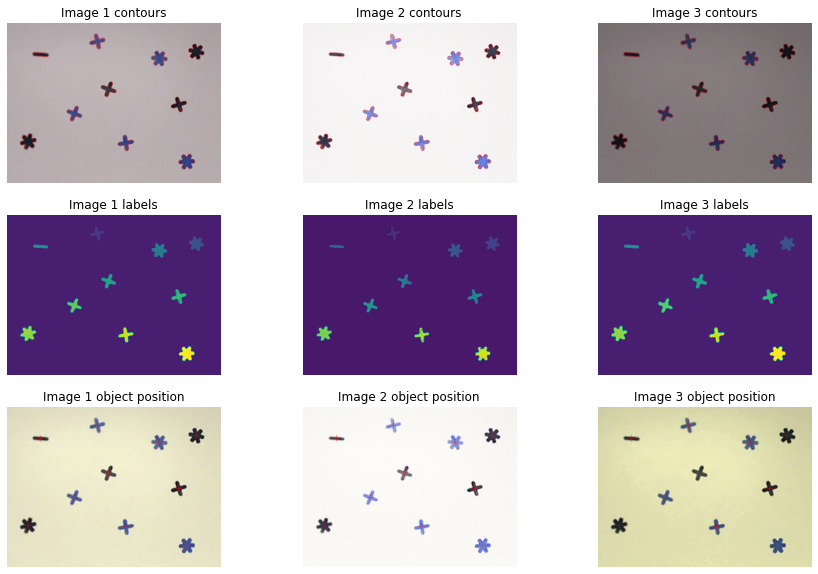

In [84]:
#plot result
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
ax[0][0].imshow(IP.overlay_contours(images[0],edges[0]))
ax[0][0].set_title('Image 1 contours')
ax[0][0].axis('off')

ax[0][1].imshow(IP.overlay_contours(images[1],edges[1]))
ax[0][1].set_title('Image 2 contours')
ax[0][1].axis('off')

ax[0][2].imshow(IP.overlay_contours(images[2],edges[2]))
ax[0][2].set_title('Image 3 contours')
ax[0][2].axis('off')

ax[1][0].imshow(labels[0])
ax[1][0].set_title('Image 1 labels')
ax[1][0].axis('off')

ax[1][1].imshow(labels[1])
ax[1][1].set_title('Image 2 labels')
ax[1][1].axis('off')

ax[1][2].imshow(labels[2])
ax[1][2].set_title('Image 3 labels')
ax[1][2].axis('off')

ax[2][0].imshow(detected_objects_img[0])
ax[2][0].set_title('Image 1 object position')
ax[2][0].axis('off')

ax[2][1].imshow(detected_objects_img[1])
ax[2][1].set_title('Image 2 object position')
ax[2][1].axis('off')

ax[2][2].imshow(detected_objects_img[2])
ax[2][2].set_title('Image 3 object position')
ax[2][2].axis('off')
plt.show()

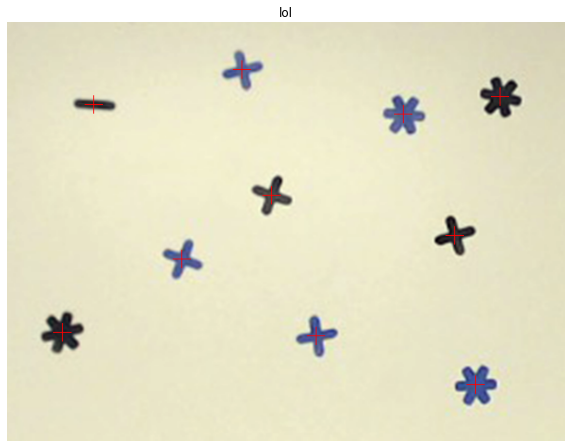

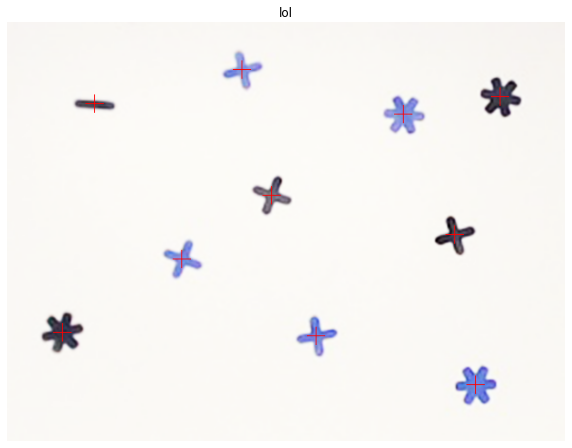

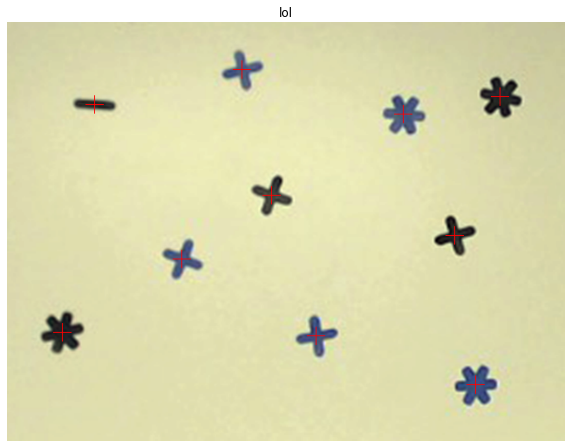

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(detected_objects_img[0])
ax.set_title('lol')
ax.axis('off')
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(detected_objects_img[1])
ax.set_title('lol')
ax.axis('off')
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(detected_objects_img[2])
ax.set_title('lol')
ax.axis('off')
plt.show()